# Global Malnutrition Analysis

In this project, we have analyzed several sources of data relevant to malnutrition amongst children ranging from the ages of infant to 5 years old. The major components of our analysis is as follows: 

1. Extracting data from various sources including UNICEF, World Bank and more (listed below) 
2. Combining malnutrition data into a single dataframe with information regarding wasting, overweight and stunting conditions amongst the global population of children from 1978 to 2021 
3. Analysing countries with the highest prevalence of malnutrition 
4. Developing a world heat map visualization to see the global malnutrition trend over the years 
5. Assessing a relationship, if any, between COVID deaths experienced by the country and prevalence of malnutrition among children

### Table of Contents

* [Data Sources](#datasources)
* [Data Importing](#dataimporting)
* [Data Cleaning](#datacleaning)
* [Visualizations for global malnutrition problem](#visualizations)
     1. [Histograms](#histogram)
     2. [Boxplots](#boxplot)
     3. [Heatmap](#heatmap)
     4. [US malnutrtion graph](#US)
     5. [TOP 5 countries with the LEAST malnutrition graphs](#top5)
     6. [TOP 5 countries with the MOST malnutrition graphs](#bot5)   
     7. [Continent Analysis](#continent)
     8. [Mapping with Geopandas](#map)
     9. [Animation of Map over time](#animation)
* [COVID Analysis](#covid)
     1. [Histogram of COVID death (min-max normalized)](#histcovid)
     2. [Highest % of COVID deaths in the world](#highestdeath)
     3. [Barplot comparing 2020 and 2021](#covidbar)
     4. [Linear regression of malnutrition % and  COVID death %](#covidlinear)
     5. [Creating a Scoring system for the countries](#covidscore)
    
    

## I. Data Sources <a class="anchor" id="datasources"></a>

1. The malnutrtion data is from UNICEF.org and it has the ratio of kids under 5 with stunt/severe stunting, wasted/severe wasted, and overweight problems at country-level from 1970 to 2021.\
(datalink: https://data.unicef.org/resources/data_explorer/unicef_f/?ag=UNICEF&df=GLOBAL_DATAFLOW&ver=1.0&dq=.NT_ANT_HAZ_NE2+NT_ANT_HAZ_NE3..&startPeriod=2016&endPeriod=2021).

2. COVID deaths data from OurWorldInData.org.\
(datalink: https://ourworldindata.org/coronavirus-source-data)

3. Continent & Country Data from Kaggle.\
(datalink: https://www.kaggle.com/statchaitya/country-to-continent) 

## II. Data Importing<a class="anchor" id="dataimporting"></a>

The data sources described above will be used to extract relevant data that we will use for our analysis.

In [74]:
# download necessary packages

# basic packages
import pandas as pd  #dataframe
import numpy as np  #calculation
import scipy as sp #calculation
# regression analysis
from sklearn import linear_model #linear regression
import statsmodels.api as sm #linear regression model
# graphing
import matplotlib.pyplot as plt #plot
import seaborn as sns #plot
from scipy.interpolate import interp1d #interpolation
from seaborn import heatmap #heatmap
# geopandas
import os
import geopandas as gpd
import descartes
from sklearn.preprocessing import MinMaxScaler, normalize
import warnings
warnings.filterwarnings('ignore')

Download each of Waste/Severe Waste/Stunt/Severe Stunt/Overweight dataset and save in panda.DataFrames and show headlines for each dataframe.


In [4]:
wasted_data = pd.read_csv("Wasted_Data.csv")
display(wasted_data[:3])

,DATAFLOW,REF_AREA:Geographic area,INDICATOR:Indicator,SEX:Sex,TIME_PERIOD:Time period,OBS_VALUE:Observation Value,UNIT_MULTIPLIER:Unit multiplier,UNIT_MEASURE:Unit of measure,OBS_STATUS:Observation Status,OBS_CONF:Observation confidentaility,...,WGTD_SAMPL_SIZE:Weighted Sample Size,OBS_FOOTNOTE:Observation footnote,SERIES_FOOTNOTE:Series footnote,DATA_SOURCE:Data Source,SOURCE_LINK:Citation of or link to the data source,CUSTODIAN:Custodian,TIME_PERIOD_METHOD:Time period activity related to when the data are collected,REF_PERIOD:Reference Period,COVERAGE_TIME:The period of time for which data are provided,AGE:Current age
0,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_WHZ_NE2: Weight-for-height <-2 SD (wast...,F: Female,2004,9.3,0: Units,PCNT: %,ER: External Reanalysis,F: Free,...,436.0,Reduced age range Age 0-5 months not covered ...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Summary report of the national nutrition surve...,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,1997-2018,Y0T4: Under 5 years old
1,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_WHZ_NE2: Weight-for-height <-2 SD (wast...,F: Female,2013,8.7,0: Units,PCNT: %,RA: Reanalysed,F: Free,...,2080089.9,Oedema data was not considered in the analysis...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Afghanistan National Nutrition Survey 2013,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,1997-2018,Y0T4: Under 5 years old
2,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_WHZ_NE2: Weight-for-height <-2 SD (wast...,F: Female,2018,4.1,0: Units,PCNT: %,RA: Reanalysed,F: Free,...,9593.1,Oedema data was not considered in the analysis...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Afghanistan Health Survey 2018,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,1997-2018,Y0T4: Under 5 years old


In [5]:
# make sure the data downloaded is for wasting only
wasted_data['INDICATOR:Indicator'].unique() 

array(['NT_ANT_WHZ_NE2: Weight-for-height <-2 SD (wasting)'], dtype=object)

In [6]:
ser_wasted_data=pd.read_csv("Severe_Wasted_Data.csv")
display(ser_wasted_data[:1])

,DATAFLOW,REF_AREA:Geographic area,INDICATOR:Indicator,SEX:Sex,TIME_PERIOD:Time period,OBS_VALUE:Observation Value,UNIT_MULTIPLIER:Unit multiplier,UNIT_MEASURE:Unit of measure,OBS_STATUS:Observation Status,OBS_CONF:Observation confidentaility,...,WGTD_SAMPL_SIZE:Weighted Sample Size,OBS_FOOTNOTE:Observation footnote,SERIES_FOOTNOTE:Series footnote,DATA_SOURCE:Data Source,SOURCE_LINK:Citation of or link to the data source,CUSTODIAN:Custodian,TIME_PERIOD_METHOD:Time period activity related to when the data are collected,REF_PERIOD:Reference Period,COVERAGE_TIME:The period of time for which data are provided,AGE:Current age
0,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_WHZ_NE3: Weight-for-height <-3 SD (seve...,F: Female,2004,4.3,0: Units,PCNT: %,ER: External Reanalysis,F: Free,...,436.0,Reduced age range Age 0-5 months not covered ...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Summary report of the national nutrition surve...,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,2004-2018,Y0T4: Under 5 years old


In [7]:
ser_wasted_data['INDICATOR:Indicator'].unique() #for severe wasting only

array(['NT_ANT_WHZ_NE3: Weight-for-height <-3 SD (severe wasting)'],
      dtype=object)

In [8]:
stunted_data = pd.read_csv("Stunt_Data.csv")
display(stunted_data[:1])

,DATAFLOW,REF_AREA:Geographic area,INDICATOR:Indicator,SEX:Sex,TIME_PERIOD:Time period,OBS_VALUE:Observation Value,UNIT_MULTIPLIER:Unit multiplier,UNIT_MEASURE:Unit of measure,OBS_STATUS:Observation Status,OBS_CONF:Observation confidentaility,...,WGTD_SAMPL_SIZE:Weighted Sample Size,OBS_FOOTNOTE:Observation footnote,SERIES_FOOTNOTE:Series footnote,DATA_SOURCE:Data Source,SOURCE_LINK:Citation of or link to the data source,CUSTODIAN:Custodian,TIME_PERIOD_METHOD:Time period activity related to when the data are collected,REF_PERIOD:Reference Period,COVERAGE_TIME:The period of time for which data are provided,AGE:Current age
0,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_HAZ_NE2: Height-for-age <-2 SD (stunting),F: Female,2004,58.5,0: Units,PCNT: %,ER: External Reanalysis,F: Free,...,436.0,Reduced age range Age 0-5 months not covered ...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Summary report of the national nutrition surve...,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,1997-2018,Y0T4: Under 5 years old


In [9]:
stunted_data['INDICATOR:Indicator'].unique() #stunting only

array(['NT_ANT_HAZ_NE2: Height-for-age <-2 SD (stunting)'], dtype=object)

In [10]:
ser_stunted_data = pd.read_csv("Severe_Stunt_Data.csv")
display(ser_stunted_data[:1])

,DATAFLOW,REF_AREA:Geographic area,INDICATOR:Indicator,SEX:Sex,TIME_PERIOD:Time period,OBS_VALUE:Observation Value,UNIT_MULTIPLIER:Unit multiplier,UNIT_MEASURE:Unit of measure,OBS_STATUS:Observation Status,OBS_CONF:Observation confidentaility,...,WGTD_SAMPL_SIZE:Weighted Sample Size,OBS_FOOTNOTE:Observation footnote,SERIES_FOOTNOTE:Series footnote,DATA_SOURCE:Data Source,SOURCE_LINK:Citation of or link to the data source,CUSTODIAN:Custodian,TIME_PERIOD_METHOD:Time period activity related to when the data are collected,REF_PERIOD:Reference Period,COVERAGE_TIME:The period of time for which data are provided,AGE:Current age
0,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_HAZ_NE3: Height-for-age <-3 SD (Severe ...,F: Female,2004,30.9,0: Units,PCNT: %,ER: External Reanalysis,F: Free,...,436.0,Reduced age range Age 0-5 months not covered ...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Summary report of the national nutrition surve...,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,2004-2018,Y0T4: Under 5 years old


In [11]:
ser_stunted_data['INDICATOR:Indicator'].unique() #severe stunting only

array(['NT_ANT_HAZ_NE3: Height-for-age <-3 SD (Severe Stunting)'],
      dtype=object)

In [12]:
overweight_data = pd.read_csv("Overweight_Data.csv")
display(overweight_data[:1])

,DATAFLOW,REF_AREA:Geographic area,INDICATOR:Indicator,SEX:Sex,TIME_PERIOD:Time period,OBS_VALUE:Observation Value,UNIT_MULTIPLIER:Unit multiplier,UNIT_MEASURE:Unit of measure,OBS_STATUS:Observation Status,OBS_CONF:Observation confidentaility,...,WGTD_SAMPL_SIZE:Weighted Sample Size,OBS_FOOTNOTE:Observation footnote,SERIES_FOOTNOTE:Series footnote,DATA_SOURCE:Data Source,SOURCE_LINK:Citation of or link to the data source,CUSTODIAN:Custodian,TIME_PERIOD_METHOD:Time period activity related to when the data are collected,REF_PERIOD:Reference Period,COVERAGE_TIME:The period of time for which data are provided,AGE:Current age
0,UNICEF:GLOBAL_DATAFLOW(1.0): Cross-sector indi...,AFG: Afghanistan,NT_ANT_WHZ_PO2: Weight-for-height >+2 SD (over...,F: Female,2004,2.6,0: Units,PCNT: %,ER: External Reanalysis,F: Free,...,436.0,Reduced age range Age 0-5 months not covered ...,UNICEF/WHO/World Bank Joint Malnutrition Estim...,Summary report of the national nutrition surve...,https://data.unicef.org/topic/nutrition/malnut...,UNICEF Division of Data Analysis Planning an...,MOF: Middle of fieldwork,NaN,1997-2018,Y0T4: Under 5 years old


In [13]:
overweight_data['INDICATOR:Indicator'].unique() #overweight only

array(['NT_ANT_WHZ_PO2: Weight-for-height >+2 SD (overweight)'],
      dtype=object)

## III. Data Cleaning<a class="anchor" id="datacleaning"></a>

We will now clean up the datasets by renaming columns for simplifcation and combining the datasets to make a concise dataframe for analysis. After the data cleaning phase, the clean dataframe should contain data for overweight, stunting and wasting among children as well as a mean that summarizes these percentages. 

In [14]:
# rename columns and only keep the relevant data columns
rename_dfs=[wasted_data,ser_wasted_data,stunted_data,ser_stunted_data,overweight_data]
rename_names=['Waste_percent','Severe_Waste_percent','Stunt_percent','Severe_Stunt_percent','Overweight_percent']
for i in range(len(rename_dfs)):
    rename_dfs[i]=rename_dfs[i].rename(columns = {"REF_AREA:Geographic area" : "Country", "SEX:Sex" : "Sex",\
                                     "TIME_PERIOD:Time period" : "Year", "OBS_VALUE:Observation Value" :rename_names[i] ,\
                                           'AGE:Current age':'Age'})
    rename_dfs[i]=rename_dfs[i][['Country','Sex','Year',rename_names[i],'Age']]
    

# showing a sample of dataframes to make sure the names are succesfully changed
display(rename_dfs[0].columns)


Index(['Country', 'Sex', 'Year', 'Waste_percent', 'Age'], dtype='object')

In [15]:
# showing a sample of dataframes to make sure the names are succesfully changed
wasted_df=rename_dfs[0]
ser_wasted_df=rename_dfs[1]
stunted_df=rename_dfs[2]
ser_stunted_df=rename_dfs[3]
overweight_df=rename_dfs[4]

In [16]:
# Combine dataframes on columns except the malnutrition percents
combine_cols=rename_dfs[0].columns.tolist()
# shown sample lines
combine_cols.pop(3)
combined_df=wasted_df.merge(ser_wasted_df,how='outer',on=combine_cols)\
            .merge(stunted_df,how='outer',on=combine_cols)\
            .merge(ser_stunted_df,how='outer',on=combine_cols)\
            .merge(overweight_df,how='outer',on=combine_cols)
combined_df.head(3)

,Country,Sex,Year,Waste_percent,Age,Severe_Waste_percent,Stunt_percent,Severe_Stunt_percent,Overweight_percent
0,AFG: Afghanistan,F: Female,2004,9.3,Y0T4: Under 5 years old,4.3,58.5,30.9,2.6
1,AFG: Afghanistan,F: Female,2013,8.7,Y0T4: Under 5 years old,3.5,39.5,19.9,5.8
2,AFG: Afghanistan,F: Female,2018,4.1,Y0T4: Under 5 years old,1.4,38.1,20.0,4.2


In [17]:
# Calculate total waste percent column from adding percentage with normal waste condition and percentage with severe waste condition
combined_df['Waste_total_percent']=combined_df['Waste_percent']+combined_df['Severe_Waste_percent']
combined_df['Stunt_total_percent']=combined_df['Stunt_percent']+combined_df['Severe_Stunt_percent']
combined_df.head(1)

,Country,Sex,Year,Waste_percent,Age,Severe_Waste_percent,Stunt_percent,Severe_Stunt_percent,Overweight_percent,Waste_total_percent,Stunt_total_percent
0,AFG: Afghanistan,F: Female,2004,9.3,Y0T4: Under 5 years old,4.3,58.5,30.9,2.6,13.6,89.4


In [18]:
# pop the previous waste & stunt columns, only keep the "waste total" and "stunt total" column
cols=['Waste_percent','Severe_Waste_percent','Stunt_percent','Severe_Stunt_percent']
for c in cols:
    combined_df.pop(c)
combined_df.head(1)

,Country,Sex,Year,Age,Overweight_percent,Waste_total_percent,Stunt_total_percent
0,AFG: Afghanistan,F: Female,2004,Y0T4: Under 5 years old,2.6,13.6,89.4


In [19]:
# save the column names for future uses
mal_type=['Mean','Overweight_percent','Waste_total_percent','Stunt_total_percent']
#malnutrition type 0=mean
#malnutrition type 1=overweight
#malnutrition type 2=waste
#malnutrition type 3=stunt

Now let's observe the properties of columns of our cleaned new combined dataframe.

In [20]:
# 1. Make sure the age is all same.
combined_df['Age'].unique()
print('All data are for kids under 5 years old.')

All data are for kids under 5 years old.


In [21]:
# Since the data only for kids under 5, we can delete this column.
del combined_df['Age']  

In [22]:
# 2. Format sex column
combined_df['Sex'].unique()

array(['F: Female', 'M: Male', '_T: Total'], dtype=object)

In [23]:
# only leave the "Total" for analysis
combined_df["Sex"] = combined_df["Sex"].str[1]
combined_df=combined_df[combined_df["Sex"]=='T']
del combined_df['Sex']  

In [24]:
# 3. Format countries and regions
country_count=len(combined_df['Country'].unique())
print('There are a total number of '+ str(country_count) + ' countries/regions in the DataFrame initially.')

There are a total number of 239 countries/regions in the DataFrame initially.


In [25]:
# Format countries, separate to 3 digit ISO code and name
split_countries= combined_df["Country"].str.split(':', expand=True)

# join to combine df
combined_df = split_countries.join(combined_df)

# rename columns
combined_df = combined_df.rename(columns = {0 : "ISO Code", 1 : "Country Name"})

# format the region
combined_df["Country Name"] = combined_df["Country Name"].str.strip()

# filter only the countrys not regions
combined_df = combined_df[combined_df["ISO Code"].str.contains("_")==False]

# remove previous columns
del combined_df['Country']

combined_df.head(3)

,ISO Code,Country Name,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent
6,AFG,Afghanistan,1997,6.5,NaN,NaN
7,AFG,Afghanistan,2004,4.6,12.1,91.1
8,AFG,Afghanistan,2013,5.3,13.5,60.8


In [26]:
new_country_count=len(combined_df['Country Name'].unique())
print('There are now a total number of '+ str(new_country_count) + ' countries in the DataFrame now.')

There are now a total number of 157 countries in the DataFrame now.


Its important to note that there are 195 countries in the world indicating that certain countries are missing from this dataset. The data from these missing countries may significantly alter the course of the analysis but we continue to analysis the dataset as is. 

In [27]:
# 4. Observe the Year columns
combined_df['Year'].unique()

array(['1997', '2004', '2013', '2018', '2000', '2005', '2009', '2017',
       '1987', '1992', '1995', '2002', '2006', '2012', '2019', '1996',
       '2007', '2015', '1994', '1998', '2010', '2016', '2001', '2011',
       '1989', '1986', '1990', '1991', '1993', '1999', '2003',
       '2013-02-16', '2013-06-16', '2014', '2008', '1985', '2019-03-14',
       '2019-11-07', '2019-08-12', '2019-08-27', '1988', '1998-01-01',
       '1998-12-01', '2018-03-13', '2018-04-09', '2020', '2012-01-06',
       '2012-08-06', '2019-01-15', '2019-09-15', '1994-01-15',
       '1994-12-17', '2016-01-15', '2016-05-11', '2016-12-01',
       '2015-05-22', '2015-09-05', '2018-07-24', '2018-09-27',
       '2010-08-22', '2010-10-24', '2016-05-15', '2016-10-01',
       '2006-03-28', '2006-11-01', '2010-06-05', '2010-10-29',
       '2012-04-11', '2012-07-16', '2018-04-02', '2018-10-23', '1983',
       '2015-01-09', '2015-04-26', '2019-02-09', '2019-08-16',
       '2017-07-01', '2017-09-19', '2010-10-04', '2010-12-21

Observe some data is recored per date instead of per year, and we only want to keep the dataframe one row per year, so we need to format the Year and keep the average of all percentages if there is more than one year appeared for each country.

In [28]:
combined_df["Year"] =  pd.to_datetime(combined_df["Year"]).dt.year
combined_df=combined_df.groupby(['ISO Code','Country Name','Year'],as_index=False).mean()
display(combined_df[:3])

,ISO Code,Country Name,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent
0,AFG,Afghanistan,1997,6.5,NaN,NaN
1,AFG,Afghanistan,2004,4.6,12.1,91.1
2,AFG,Afghanistan,2013,5.3,13.5,60.8


In [29]:
#observe year ranges
years=combined_df['Year'].unique()
print(sorted(years))

[1983, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]


In [30]:
# 5. Now our dataframe is cleaned and we are ready to drop rows with Na values
combined_df.dropna(inplace=True) #drop NaN

In [31]:
# create a new column of malnutrition score for mean of the five malnutrition factor
combined_df['Mean']=combined_df.iloc[:,4:9].mean(axis=1)
combined_df.head(3)

,ISO Code,Country Name,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean
1,AFG,Afghanistan,2004,4.6,12.1,91.1,51.60
2,AFG,Afghanistan,2013,5.3,13.5,60.8,37.15
3,AFG,Afghanistan,2018,4.1,6.7,57.6,32.15


Its important to note here that the calculated mean of the various malnutrition conditions may not be the most ideal representation of each country during that year but we've chosen this method as a relatively high level status of the country. 

## IV. Visualizations for global malnutrition problem<a class="anchor" id="visualizations"></a>

### 1. Histograms <a class="anchor" id="histogram"></a>

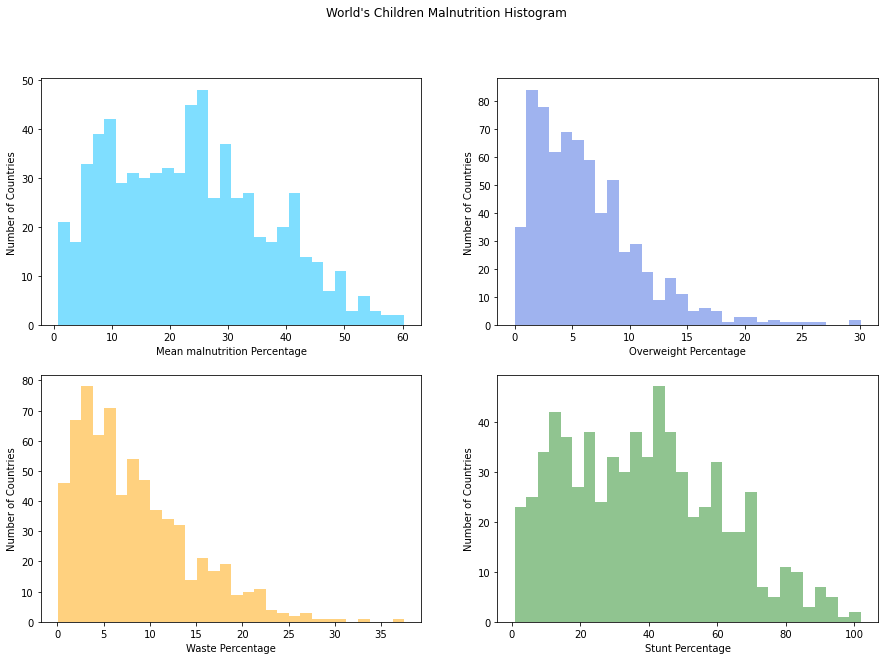

In [32]:
# now observe overweight/waste/stunt 
fig, axis = plt.subplots(2,2) 
fig.suptitle("World's Children Malnutrition Histogram")

# Mean
axis[0,0].hist(combined_df[mal_type[0]],bins=30,color='deepskyblue',alpha=0.5)
#axis[0,0].set_title("Mean malnutrition")
axis[0,0].set_xlabel('Mean malnutrition Percentage')
axis[0,0].set_ylabel('Number of Countries')

# Overweight
axis[0,1].hist(combined_df[mal_type[1]],bins=30,color='royalblue',alpha=0.5)
#axis[0,1].set_title("Overweight")
axis[0,1].set_xlabel('Overweight Percentage')
axis[0,1].set_ylabel('Number of Countries')

# Waste
axis[1,0].hist(combined_df[mal_type[2]],bins=30,color='orange',alpha=0.5)
#axis[1,0].set_title("Waste")
axis[1,0].set_xlabel('Waste Percentage')
axis[1,0].set_ylabel('Number of Countries')

# Stunt
axis[1,1].hist(combined_df[mal_type[3]],bins=30,color='forestgreen',alpha=0.5)
#axis[1,1].set_title("Stunt")
axis[1,1].set_xlabel('Stunt Percentage')
axis[1,1].set_ylabel('Number of Countries')


fig.set_size_inches(15, 10)
plt.show()

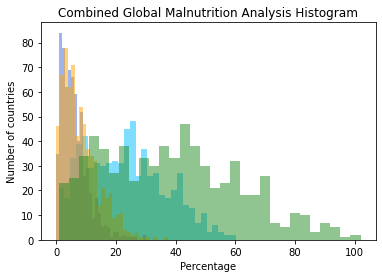

In [33]:
plt.hist(combined_df[mal_type[0]],bins=30,color='deepskyblue',alpha=0.5)
plt.hist(combined_df[mal_type[1]],bins=30,color='royalblue',alpha=0.5)
plt.hist(combined_df[mal_type[2]],bins=30,color='orange',alpha=0.5)
plt.hist(combined_df[mal_type[3]],bins=30,color='forestgreen',alpha=0.5)
plt.xlabel('Percentage')
plt.ylabel('Number of countries')
plt.title('Combined Global Malnutrition Analysis Histogram')
fig.set_size_inches(15, 10)
plt.show()

### 2. Boxplots<a class="anchor" id="boxplot"></a>

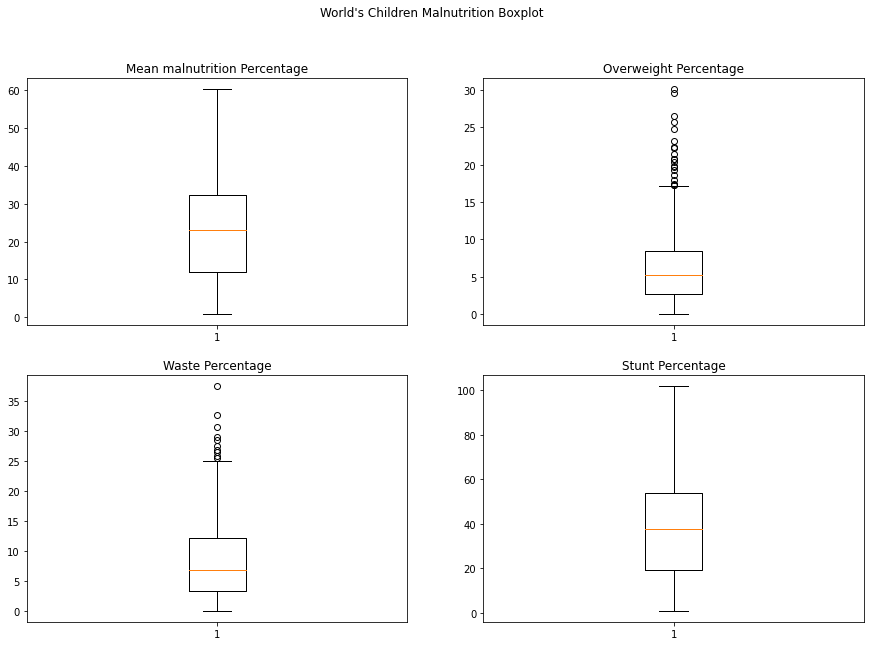

In [34]:
# now observe overweight/waste/stunt 
fig, axis2 = plt.subplots(2,2) 
fig.suptitle("World's Children Malnutrition Boxplot")

# Mean
axis2[0,0].boxplot(combined_df[mal_type[0]])
axis2[0,0].set_title("Mean malnutrition Percentage")

# Overweight
axis2[0,1].boxplot(combined_df[mal_type[1]])
axis2[0,1].set_title("Overweight Percentage")

# Waste
axis2[1,0].boxplot(combined_df[mal_type[2]])
axis2[1,0].set_title("Waste Percentage")

# Stunt
axis2[1,1].boxplot(combined_df[mal_type[3]])
axis2[1,1].set_title("Stunt Percentage")

fig.set_size_inches(15, 10)
plt.show()


### 3. Heatmap <a class="anchor" id="heatmap"></a>

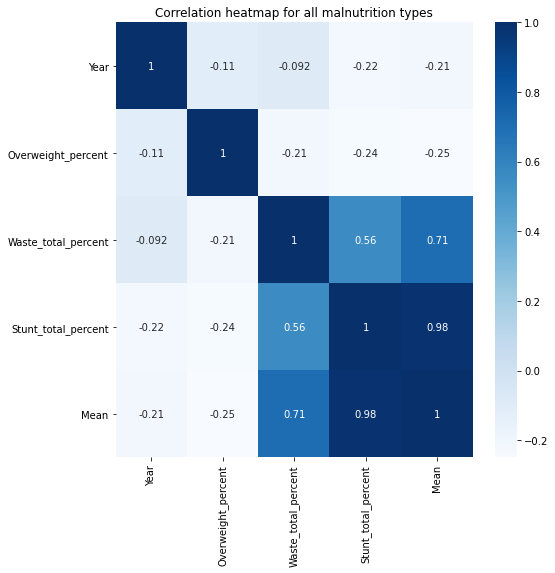

In [35]:
# observe correlation map
corr = combined_df.corr() # train is a pandas dataframe 
plt.figure(figsize = (8, 8))
heatmap(corr, cmap = 'Blues',annot=True)
plt.title('Correlation heatmap for all malnutrition types')
plt.show()

The above heatmap shows the following:
1. The relationship between the Mean and the Stunt percentage is relatively linear, which means stunt has been the most serious global malnutrition problem.
2. An obvious note, the correlation between overweight and stunting & wasting are negative, indicating negative correlation. This makes sense since it can be largely assumed that the factors that contribute to stunting and wasting would not be the same factors that contribute to overweight. 
3. It's evident that the negative correlation between the years and each of the conditions indicate that as the years have progressed, the percentage of malnutrition is decreasing over the years, the world has been improving!

### 5. US malnutrition graph<a class="anchor" id="US"></a>

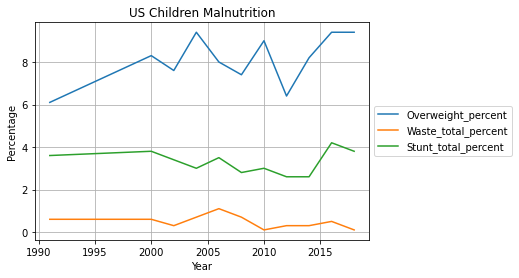

In [36]:
# Now Observe US first
country_df=combined_df.copy()
country_df.index = country_df["ISO Code"] #make the iso code as index 

country_df.loc['USA'].plot(x='Year', y=['Overweight_percent','Waste_total_percent','Stunt_total_percent'])
plt.title('US Children Malnutrition')
plt.xlabel('Year') # x label
plt.ylabel('Percentage') # y label
plt.grid(which='major', axis='both') # creating dash
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.set_size_inches(10, 10)
plt.show()


Using interpolation to smooth the linear graph above so we will able to to view more continuous and time-based trends. 

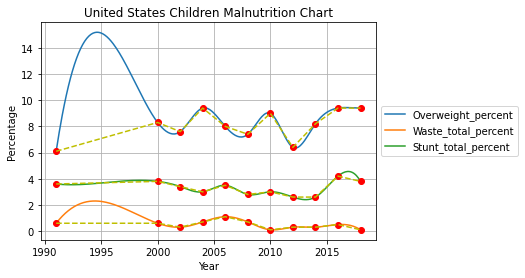

In [37]:
# create a function to smooth the graph later
# use interpld from scipy to smooth the lines

def countryGraph(countryISO):
    countryData=country_df.loc[countryISO]
    country_name=countryData['Country Name'][1]
    x=countryData['Year'] # x is the year
    X_=np.linspace(x.min(), x.max(),300) #X_ is the new x with linspace
    d=countryData[mal_type[1:]] #z is actual datapoints
    for i in range(1,4): 
        y=countryData[mal_type[i]] #interate the plot each y as malnutrtion types
        smooth_model = interp1d(x, y, kind = "cubic") #smooth with interplation
        f=smooth_model(X_) #f is the new y 
        plt.plot(X_,f) #plot
    plt.plot(x, d, 'ro') # red dots are the actual data points
    plt.plot(x, d, 'y--') # yellow dash lines are the linear plot
    plt.grid(which='major', axis='both') # creating dash
    plt.xlabel('Year') # x label
    plt.ylabel('Percentage') # y label
    plt.title(country_name+str(' Children Malnutrition Chart')) # title
    plt.legend(mal_type[1:],loc='center left', bbox_to_anchor=(1, 0.5)) # legend
    plt.show()
    
# Let's observe US data again now.
countryGraph('USA')


Observed that children under 5 in US have a relative high overweight problem, lower stunt problem, and the lowest waste problem.

### 5. TOP 5 countries with the LEAST malnutrition graphs<a class="anchor" id="top5"></a>

Let's groupby countries and observe the top 5 and bottom 5 countris with the highest and lowest overall mean malnutrition values. Because the minimum required datapoint of cubic spline is 4, we want to filter the country with 4 or more years of report.


In [38]:
country_count_all=combined_df.groupby(by=['ISO Code','Country Name'],as_index=False).count()
country_count_all.rename(columns={'Mean':'Count'},inplace=True)
country_count_all=country_count_all[['ISO Code','Count']]

# filter country with >= 4 data points
country_count=country_count_all[country_count_all['Count']>=4]
country_count=country_count[['ISO Code','Count']]

# this is all countries
print('There are '+str(len(country_count_all))+' countries total.')

# this is all countries with 4+ data points 
print('There are '+str(len(country_count))+' countries with 4+ data points.')


There are 147 countries total.
There are 86 countries with 4+ data points.


In [39]:
# now we are creating a country_rank dataframe to observe countries with 4+ data points in the rank of their malnutrition means.
country_rank=combined_df.groupby(by=['ISO Code','Country Name'],as_index=False).mean()
country_rank=country_rank.merge(country_count,how='inner',on='ISO Code')
country_rank=country_rank.sort_values(by='Mean')
country_rank["Year"]=country_rank["Year"].astype(int)
display(country_rank[:3])


,ISO Code,Country Name,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean,Count
80,USA,United States,2007,8.109091,0.481818,3.300000,1.890909,11
36,KWT,Kuwait,2007,8.328571,3.178571,5.807143,4.492857,14
45,MKD,North Macedonia,2008,12.350000,3.175000,9.525000,6.350000,4


In [40]:
clean=country_rank.groupby(["Country Name", "Year"],as_index = False).mean()
iso_codes = combined_df[["ISO Code", "Country Name"]].drop_duplicates()
clean_rank = iso_codes.merge(clean, on = "Country Name")
clean_rank = clean_rank.sort_values(by = ["Mean"], ascending = True)
display(clean_rank[:3])

,ISO Code,Country Name,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean,Count
80,USA,United States,2007,8.109091,0.481818,3.300000,1.890909,11.0
36,KWT,Kuwait,2007,8.328571,3.178571,5.807143,4.492857,14.0
45,MKD,North Macedonia,2008,12.350000,3.175000,9.525000,6.350000,4.0


In [41]:
# Save the 5 countries with lowest malnutrition mean for observation, save as top5 
top5=clean_rank[:5]['Country Name'].tolist()
display(top5)
# The 5 countries with least amount of children malnutrition problem

['United States', 'Kuwait', 'North Macedonia', 'Serbia', 'Uruguay']

In [42]:
# Save these 5 countries' corresponding ISO code as top5ISO
top5ISO=clean_rank[:5]['ISO Code'].tolist()
display(top5ISO)


['USA', 'KWT', 'MKD', 'SRB', 'URY']

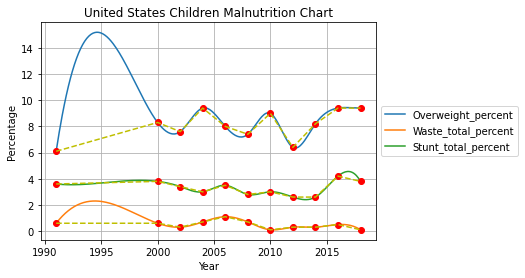

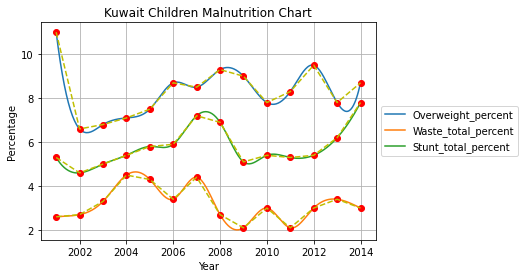

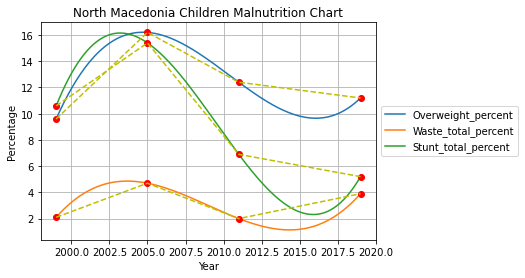

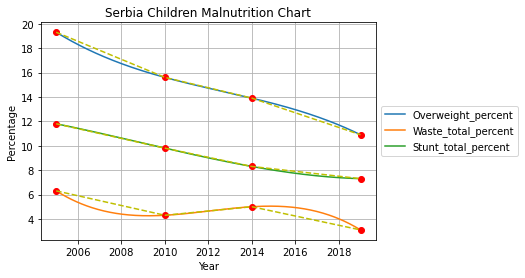

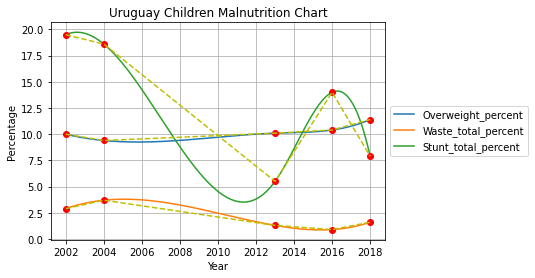

In [43]:
# Plot graphs to observe the trend for each malnutrition problem at country level for top 5 countries
for i in top5ISO:
    countryGraph(i)


From the graphs above we observed that the biggest malnutrition problem in top 5 countries is overweight, and it ranges from 10% to 20%, and the smallest problem is waste which ranges less than 5%. 

### 6. TOP 5 countries with the MOST malnutrition graphs<a class="anchor" id="bot5"></a>

In [44]:
# Now ave the 5 countries with most amount malnutrition mean for observation, save as bot5 
bot5=clean_rank[-5:]['Country Name'].tolist()
display(bot5) 


['Niger', 'Madagascar', 'Burundi', 'Yemen', 'Timor-Leste']

In [45]:
# Save these 5 countries' corresponding ISO code as bot5ISO
bot5ISO=clean_rank[-5:]['ISO Code'].tolist()
display(bot5ISO)


['NER', 'MDG', 'BDI', 'YEM', 'TLS']

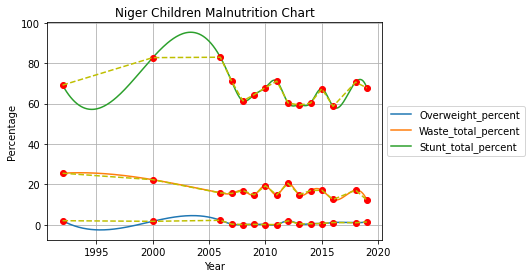

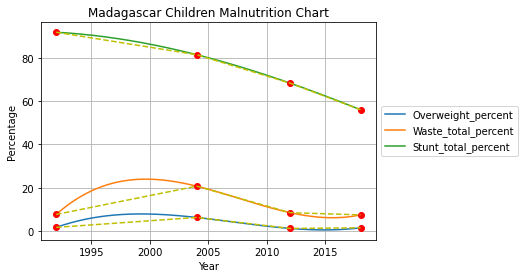

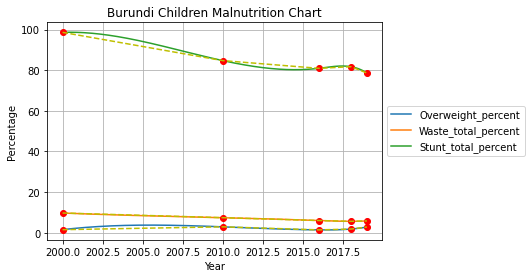

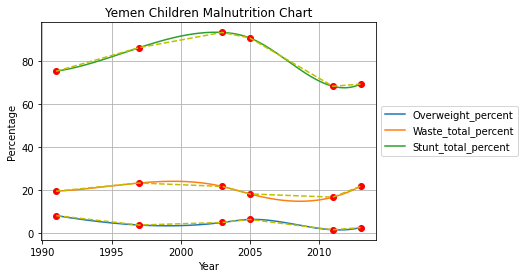

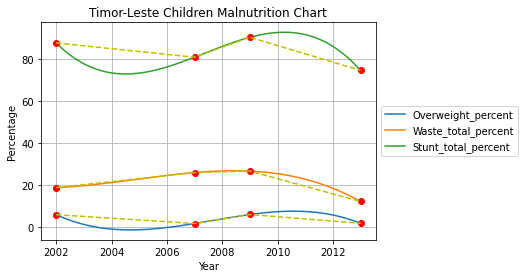

In [46]:
# Plot graphs to observe the trend for each malnutrition problem at country level for top 5 countries
for i in bot5ISO:
    countryGraph(i)


From the graphs above we observed that the biggest malnutrition problem in bottom 5 countries is stunt, and it ranges from 60% to 100%, and the smallest problem is overweight which ranges less than around 8%. 

### 7. PCA Compression Analysis

Due to the numerous countries present in this analysis, visually observing the 3 main data factors (overweight, stunting and wasting) can provide valuable insight. In this PCA compression component, we attempt to compress this data into 2 dimensions. 

In [47]:
new_analysis = combined_df.groupby(["Country Name"]).mean()

new_analysis = new_analysis.T # transposing data table

new_analysis = new_analysis.drop(["Year"], axis = 0)
new_analysis = new_analysis.drop(["Mean"], axis = 0)
new_analysis['Malnutrition Factor'] = new_analysis.index
new_analysis.reset_index(drop=True, inplace=True)
new_analysis.insert(0, 'Malnutrition Factor', new_analysis.pop("Malnutrition Factor")) # bringing key column of malnutrition factors to the front
display(new_analysis)

Country Name,Malnutrition Factor,Afghanistan,Albania,Algeria,Angola,Argentina,Armenia,Azerbaijan,Bangladesh,Barbados,...,Ukraine,United Republic of Tanzania,United States,Uruguay,Uzbekistan,Vanuatu,Viet Nam,Yemen,Zambia,Zimbabwe
0,Overweight_percent,4.666667,23.625,12.828571,2.55,9.9,13.62,11.150,1.722222,12.2,...,26.5,4.445455,8.109091,10.26,9.266667,4.80,3.48750,4.500000,7.228571,5.7125
1,Waste_total_percent,10.766667,11.750,8.285714,7.75,1.4,5.54,8.975,17.500000,8.8,...,12.0,6.554545,0.481818,2.08,7.000000,7.00,10.56875,20.200000,7.585714,5.3750
2,Stunt_total_percent,69.833333,38.550,25.728571,74.40,10.0,22.08,30.975,59.711111,10.8,...,35.6,57.345455,3.300000,13.10,25.233333,36.75,45.64375,80.666667,68.957143,41.2250


In [48]:
countries = new_analysis.columns.to_list()
countries.remove("Malnutrition Factor")

factors = new_analysis["Malnutrition Factor"]

In [49]:
X_raw = new_analysis[countries].values.T #creating a matrix of important values 

s = min(X_raw.shape)

X = X_raw - np.mean(X_raw, axis=0)

U, Sigma, VT = np.linalg.svd(X, full_matrices=False) # using SVD linear algebra function to 


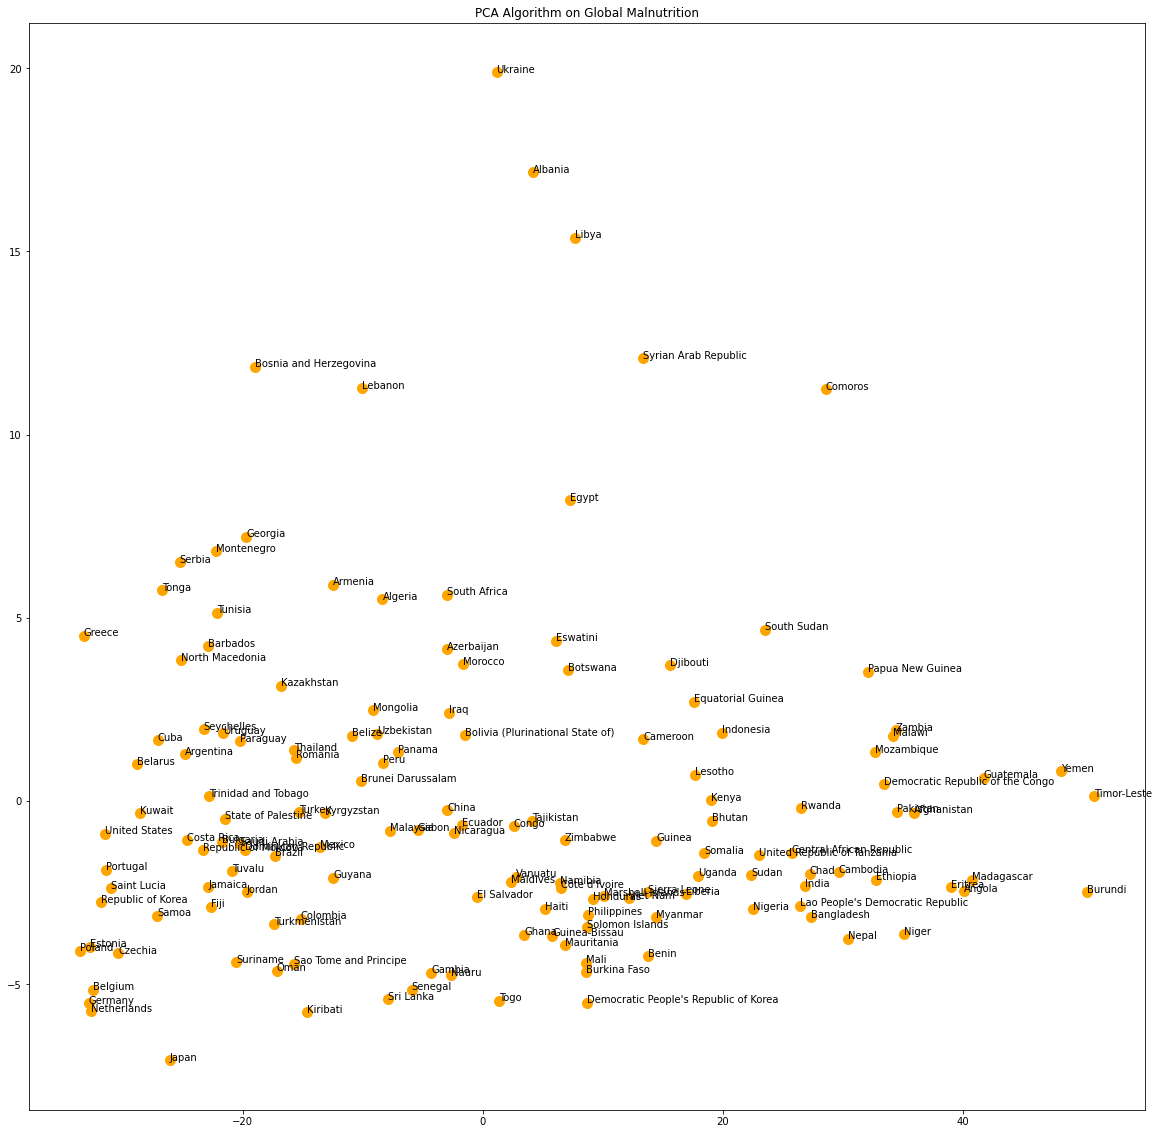

In [50]:
fig = plt.figure(figsize=(20, 20))
Y_k = X.dot(VT[0:10, :].T)
 
plt.scatter(Y_k[:, 0], Y_k[:, 2], c = "orange", s = 100) # creating a scatterplot of countries 
plt.title("PCA Algorithm on Global Malnutrition")
for x, y, label in zip(Y_k[:, 0], Y_k[:, 2], countries):
    plt.annotate(label, xy=(x, y))

### 8. Continent Analysis<a class="anchor" id="continent"></a>

In [51]:
country_rank_all=combined_df.groupby(by=['ISO Code','Country Name'],as_index=False).mean()
country_rank_all=country_rank_all.merge(country_count_all,how='inner',on='ISO Code')
country_rank_all=country_rank_all.sort_values(by='Mean', ascending = False)
country_rank_all["Year"]=country_rank_all["Year"].astype(int)
display(country_rank_all[:3])

,ISO Code,Country Name,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean,Count
128,TLS,Timor-Leste,2007,3.65,20.725,83.300000,52.012500,4
143,YEM,Yemen,2003,4.50,20.200,80.666667,50.433333,6
6,BDI,Burundi,2012,2.08,6.900,84.900000,45.900000,5


In [52]:
clean_all=country_rank_all.groupby(["Country Name", "Year"],as_index = False).mean()

clean_rank_all = iso_codes.merge(clean_all, on = "Country Name")

clean_rank_all = clean_rank_all.sort_values(by = ["Mean"], ascending = False)
display(clean_rank_all[:3])

,ISO Code,Country Name,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean,Count
128,TLS,Timor-Leste,2007,3.65,20.725,83.300000,52.012500,4.0
143,YEM,Yemen,2003,4.50,20.200,80.666667,50.433333,6.0
6,BDI,Burundi,2012,2.08,6.900,84.900000,45.900000,5.0


In [53]:
continent = pd.read_csv("countryContinent.csv")

continent = continent[["country", "continent"]]

joined = clean_rank_all.merge(continent, left_on = "Country Name", right_on = "country")

joined = joined.drop(columns = "country")

In [54]:
display(joined[:3])

,ISO Code,Country Name,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean,Count,continent
0,TLS,Timor-Leste,2007,3.65,20.725,83.300000,52.012500,4.0,Asia
1,YEM,Yemen,2003,4.50,20.200,80.666667,50.433333,6.0,Asia
2,BDI,Burundi,2012,2.08,6.900,84.900000,45.900000,5.0,Africa


In [55]:
by_continent = joined.groupby(["Year", "continent"], as_index = False).mean()

display(by_continent[:3])

,Year,continent,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean,Count
0,1997,Americas,6.633333,3.100000,17.133333,10.116667,3.0
1,1999,Asia,7.087500,4.262500,31.537500,17.900000,8.0
2,2000,Americas,4.750000,2.133333,34.316667,18.225000,6.0


In the Global Malnutrition Trend, the following can be observed:

1. All continents seem to experience a downward trend in malnutrition cases towards the last 2-3 years 
2. A rapid spike in cases can be observed during 2003-2004. The SARS epidemic also began around this time which may have exacerbated the conditions for children already suffering from malnutrition in continents such as Asia and Europe
3. Its also important to note that this particular graph also accounts for overweight conditions which, depending on the global context and poverty status. For example, children in impoverished households with access to carbs but not to other nutrients could gain weight due to financial hardship or inavailability while children in certain 1st world countries may have access and capability to purchase nutritional food but families may simply choose not to due to other reasons. 

In [56]:
for c in sorted(continents):
    dfc=by_continent[by_continent['continent']==c]
    xc=dfc['Year']
    Xc=np.linspace(xc.min(), xc.max(),300)
    yc=dfc['Mean']
    f1= interp1d(xc, yc, kind = "cubic")
    yc_=f1(Xc)

#Plotting the Graph
    plt.title("Global Child Malnutrition Data Chart")
    plt.legend(continents,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(which='major', axis='both')
    plt.plot(Xc, yc_,linewidth=3)

NameError: name 'continents' is not defined

In [ ]:
for c in sorted(continents):
    dfc=by_continent[by_continent['continent']==c]
    xc=dfc['Year']
    Xc=np.linspace(xc.min(), xc.max(),300)
    yc=dfc['Stunt_total_percent']
    f1= interp1d(xc, yc, kind = "cubic")
    yc_=f1(Xc)

#Plotting the Graph
    plt.title("Global Child Stunting Data Chart")
    plt.legend(continents,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(which='major', axis='both')
    plt.plot(Xc, yc_,linewidth=3)

In this Stunting dataset, the following can be observed: 

1. While Africa's stunting trend is upward, the other continents end upon an upward trend. 
2. Its interesting to know the relatively close trend followed by Asia and Europe. 

In [ ]:
for c in sorted(continents):
    dfc=by_continent[by_continent['continent']==c]
    xc=dfc['Year']
    Xc=np.linspace(xc.min(), xc.max(),300)
    yc=dfc['Overweight_percent']
    f1= interp1d(xc, yc, kind = "cubic")
    yc_=f1(Xc)

#Plotting the Graph
    plt.title("Global Child Overweight Data Chart")
    plt.legend(continents,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(which='major', axis='both')
    plt.plot(Xc, yc_,linewidth=3)

In this overweight dataset, the following can be observed: 

1. Africa's trend seems to have the most variation throughout the timespan. While the 2001 data point may be a potential outlier, the 2008 data point may be attributed to a historical event such as the food production crisis in Africa or potentially due to multiple countries being included in the dataset during this year. 
2. All the continents are on an upward trend for increasing overweight child population except for the Americas. Its also to be noted that the dataset does not reach the same end year. 

In [ ]:
for c in sorted(continents):
    dfc=by_continent[by_continent['continent']==c]
    xc=dfc['Year']
    Xc=np.linspace(xc.min(), xc.max(),300)
    yc=dfc['Waste_total_percent']
    f1= interp1d(xc, yc, kind = "cubic")
    yc_=f1(Xc)

#Plotting the Graph
    plt.title("Global Child Wasting Data Chart")
    plt.legend(continents,loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(which='major', axis='both')
    plt.plot(Xc, yc_,linewidth=3)

In this Wasting dataset, the following can be observed: 
    
1. Europe looks to be experiencing the most drastic peaks in wasting percentage both around 2012 and 2003. 
2. Both Africa and the Americas observe a peak during 2008. Perhaps the 2008 peak for the Americas may have some connection with the housing crisis and following recession period. Its also important to note that the Americas is a big region not only attributed to the United States. 

### 9. Mapping with Geopandas <a class="anchor" id="map"></a>

Let's view how these effects of malnutrition apply on a global scale. In this section, you'll see maps of the severity of each measurment of malnutrition as recorded in year 2020.

In [57]:
# import map
world_map = gpd.read_file(os.getcwd()+'/World_Map/World_Countries__Generalized_.shp')

In [58]:
map_all = world_map.merge(combined_df, how='left', left_on='COUNTRYAFF', right_on='Country Name')
print('Verifying data has combined')
display(map_all.head(2))

Verifying data has combined


,FID,COUNTRY,ISO,COUNTRYAFF,AFF_ISO,SHAPE_Leng,SHAPE_Area,geometry,ISO Code,Country Name,Year,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean
0,1,American Samoa,AS,United States,US,0.600124,0.01372,"POLYGON ((-170.74390 -14.37555, -170.74942 -14...",USA,United States,1991.0,6.1,0.6,3.6,2.1
1,1,American Samoa,AS,United States,US,0.600124,0.01372,"POLYGON ((-170.74390 -14.37555, -170.74942 -14...",USA,United States,2000.0,8.3,0.6,3.8,2.2


In [59]:
print('Overweight observations range', np.nanmin(map_all['Overweight_percent'].values), '% to', np.nanmax(map_all['Overweight_percent'].values), '%.')
print('Wasted observations range', np.nanmin(map_all['Waste_total_percent'].values), '% to', np.nanmax(map_all['Waste_total_percent'].values), '%.')
print('Stunted observations range', np.nanmin(map_all['Stunt_total_percent'].values), '% to', np.nanmax(map_all['Stunt_total_percent'].values), '%.')

Overweight observations range 0.1 % to 30.1 %.
Wasted observations range 0.1 % to 37.5 %.
Stunted observations range 0.9 % to 101.9 %.


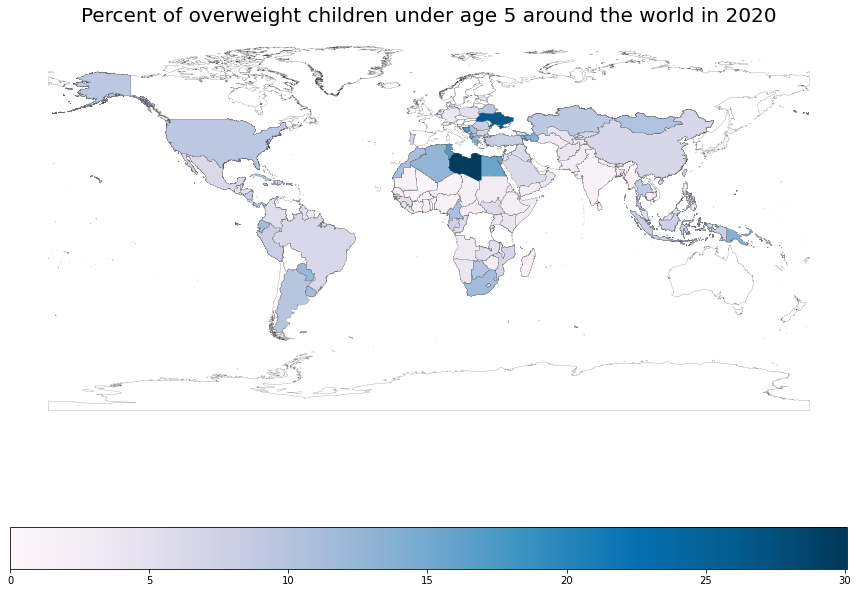

In [60]:
# map with all overweight indicators
vmin, vmax = 0, np.nanmax(map_all['Overweight_percent'].values)
coloro = 'PuBu'

figo, axo = plt.subplots(1, figsize = (15,12))
map_all.plot(column='Overweight_percent', cmap=coloro, ax=axo, linewidth=0.2, edgecolors='0.3')
bar_infoo = plt.cm.ScalarMappable(cmap=coloro, norm=plt.Normalize(vmin=vmin, vmax=vmax))
axo.set_title('Percent of overweight children under age 5 around the world in 2020', fontdict={'fontsize':20})
axo.set_axis_off()
bar_infoo._A = []
cbar = figo.colorbar(bar_infoo, orientation='horizontal')

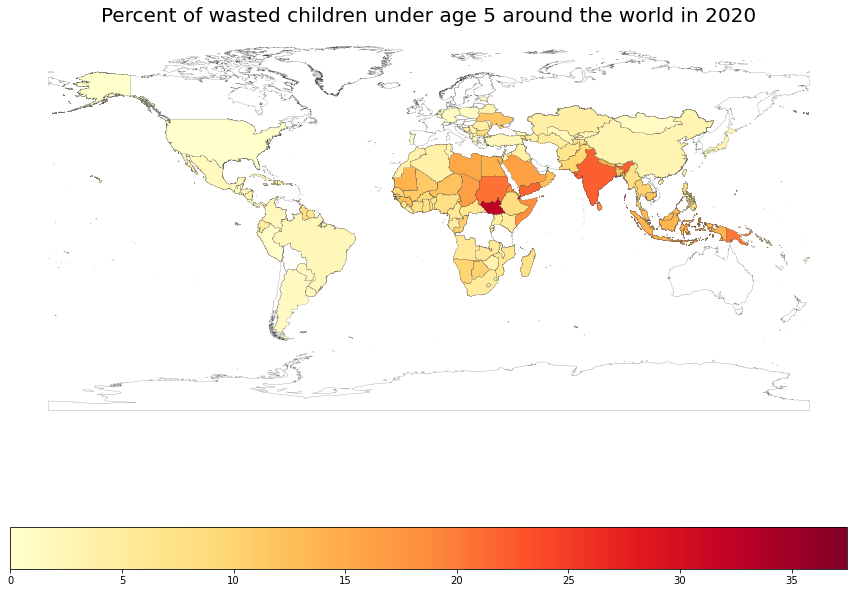

In [61]:
# map with all waste indicators
vmin, vmax = 0, np.nanmax(map_all['Waste_total_percent'].values)
colorw = 'YlOrRd'

figw, axw = plt.subplots(1, figsize = (15,12))
map_all.plot(column='Waste_total_percent', cmap=colorw, ax=axw, linewidth=0.2, edgecolors='0.3')
bar_infow = plt.cm.ScalarMappable(cmap=colorw, norm=plt.Normalize(vmin=vmin, vmax=vmax))
axw.set_title('Percent of wasted children under age 5 around the world in 2020', fontdict={'fontsize':20})
axw.set_axis_off()
bar_infow._A = []
cbar = figw.colorbar(bar_infow, orientation='horizontal')

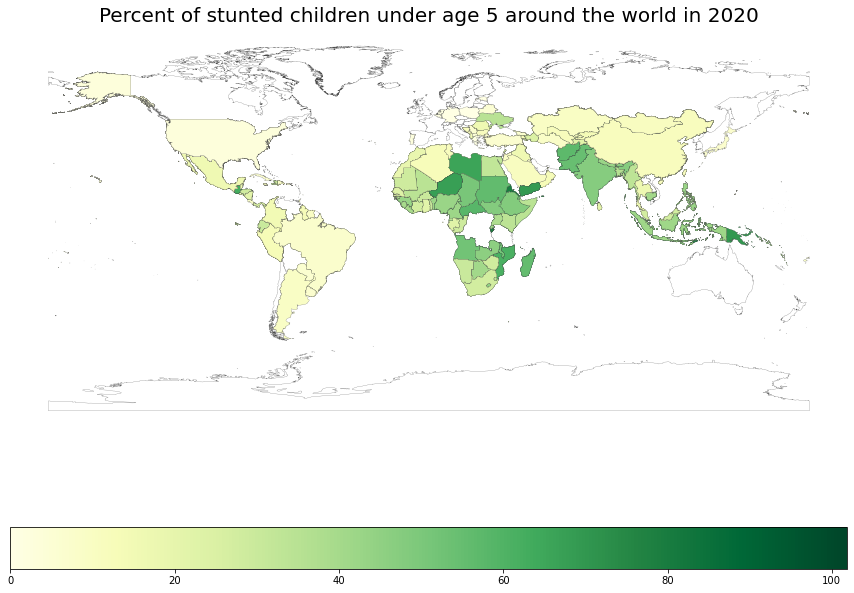

In [62]:
# map with all stunt indicators
vmin, vmax = 0, np.nanmax(map_all['Stunt_total_percent'].values)
colors = 'YlGn'

figs, axs = plt.subplots(1, figsize = (15,12))
map_all.plot(column='Stunt_total_percent', cmap=colors, ax=axs, linewidth=0.2, edgecolors='0.3')
bar_infos = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=vmin, vmax=vmax))
axs.set_title('Percent of stunted children under age 5 around the world in 2020', fontdict={'fontsize':20})
axs.set_axis_off()
bar_infos._A = []
cbar = figs.colorbar(bar_infos, orientation='horizontal')

Generally, the measurements of malnutrition in children seem to be concentrated in the continent Africa. We see Libya and Ukraine reporting high obesity, South Sudan reporting high wasting, and many countries reporting stunting.

### 10. Animation of Map over time<a class="anchor" id="animation"></a>

Next, we have created gifs for each malnutrition measurement that explores the changes around the world over a span of about 35 years. It is interesting to watch some areas "heal" and others report more drasticee severity.

Each type of measurement has its own maximum and the scale is shown below the map. Some countries remain white, which means they have not reported the measurements to UNICEF for this time period. The map boundaries are based on recent data, so keep in mind that some country names have also changed since the beginning of the time covered. Changes in country names may affect how the data is able to be displayed because the map data is merged with the malnutrition data on each country's name.

In [63]:
# list of years
min_year = int(map_all['Year'].min())
max_year = int(map_all['Year'].max())+1
list_of_years = list(range(min_year, max_year))
print('Years range from', min(list_of_years), 'to', max(list_of_years))

Years range from 1986 to 2020


In [64]:
# list of countries (we will use this list again in the scoring section)
countries = map_all['COUNTRYAFF'].unique()
print('There are', len(countries), 'countries listed.')

There are 197 countries listed.


In [65]:
# save all the maps in the pictures folder
output_path = os.getcwd()+'/pictures'
filenames = []

The algorithm below creates a full map for each year and merges it with the data for the type of malnutrition measurement passed in. It also takes in the parameters for the color and axis to stay consistent with the established color scheme for each type of malnutrition measurement. The pictures created for each year are then saved into a file.

In [66]:
# algorithm to make a map for each year and save as jpg
def make_maps(map_col, color, ax, list_of_years = list(range(2000,2020))):
    # start the for loop to create one map per year
    for year in list_of_years:
        # narrow the data to the year desired
        yearly = combined_df.loc[combined_df['Year'] == year].reset_index(drop=True)
        maps = world_map.merge(yearly, how='left', left_on='COUNTRYAFF', right_on='Country Name')
        
        # normalize across all years
        vmin = min(combined_df[map_col])
        vmax = max(combined_df[map_col])

        # create map
        fig = maps.plot(column=map_col,
                        cmap=color,
                        figsize=(16,12),
                        linewidth=0.3,
                        edgecolor='0.3',
                        ax=ax,
                        norm=plt.Normalize(vmin=vmin, vmax=vmax))
        
        # add a title
        fig.set_title(map_col + ' children under age 5 in ' + str(year), \
                  fontdict={'fontsize': '20',
                             'fontweight' : '3'})

        # remove axis of chart
        fig.set_axis_off()
        
        # this will save the figure as a high-res jpg
        filename = str(year)+'_'+map_col+'.jpg'
        filepath = os.path.join(output_path, filename)
        filenames.append(filename)
        chart = fig.get_figure()
        chart.savefig(filepath, dpi=300)

In [67]:
# make all the annual maps (each of these cells takes a lot of processing power and some time to run)
make_maps('Overweight_percent', coloro, axo, list_of_years)

<Figure size 432x288 with 0 Axes>

In [68]:
make_maps('Waste_total_percent', colorw, axw, list_of_years)

<Figure size 432x288 with 0 Axes>

In [69]:
make_maps('Stunt_total_percent', colors, axs, list_of_years)

<Figure size 432x288 with 0 Axes>

This function pulls the maps for each year into a single gif. The parameters passed into this function are which folder to find the pictures, which file to save the gif, and some optional parameters on the length of the animation and how many times it loops.

In [70]:
# pull the created pictures into a gif
import glob
from PIL import Image

def make_gif(fp_in, fp_out, duration = 400, loop = 3):
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=duration, loop=loop)

In [1815]:
# filepaths for overweight gif
o_fp_in = os.getcwd()+'/pictures/*_Overweight*.jpg'
o_fp_out = os.getcwd()+'/overweight.gif'

#make overweight gif
make_gif(o_fp_in, o_fp_out)

In [1816]:
# filepaths for wasted
w_fp_in = os.getcwd()+'/pictures/*_Waste*.jpg'
w_fp_out = os.getcwd()+'/waste.gif'

#make wasted gif
make_gif(w_fp_in, w_fp_out)

In [1817]:
# filepaths for stunted
s_fp_in = os.getcwd()+'/pictures/*_Stunt*.jpg'
s_fp_out = os.getcwd()+'/stunt.gif'

#make stunted gif
make_gif(s_fp_in, s_fp_out)

View the gifs we made!

![SegmentLocal](overweight.gif "segment")

![SegmentLocal](waste.gif "segment")

![SegmentLocal](stunt.gif "segment")

## IV. Covid Analysis<a class="anchor" id="covid"></a>

Now we want to observe how does a country's children's malnutrtion percentage correlated to their Covid's death.

In [71]:
# Download covid vaccine rate data to covid_data from https://ourworldindata.org/covid-vaccinations
covid_data=pd.read_csv("owid-covid-data.csv")
covid_data.tail(5)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
151543,ZWE,Africa,Zimbabwe,2021-12-28,207548.0,2099.0,1397.143,4940.0,32.0,17.286,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
151544,ZWE,Africa,Zimbabwe,2021-12-29,207548.0,0.0,1163.429,4940.0,0.0,16.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
151545,ZWE,Africa,Zimbabwe,2021-12-30,211728.0,4180.0,1483.429,4997.0,57.0,20.286,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
151546,ZWE,Africa,Zimbabwe,2021-12-31,213258.0,1530.0,1503.143,5004.0,7.0,19.000,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN
151547,ZWE,Africa,Zimbabwe,2022-01-01,214214.0,956.0,1495.429,5017.0,13.0,18.857,...,1.6,30.7,36.791,1.7,61.49,0.571,NaN,NaN,NaN,NaN


In [2470]:
#before 12/31/2020, the total case and death for each countries
covid_data=covid_data[covid_data['date']<'2021-01-01']
covid_df=covid_data.groupby(by='iso_code').max()
display(covid_df[:5])

,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
iso_code,,,,,,,,,,,,,,,,,,,,,
ABW,North America,Aruba,2020-12-31,5489.0,176.0,90.143,49.0,3.0,1.000,51205.747,...,NaN,NaN,NaN,NaN,76.29,NaN,66.2,14.96,59.84,617.566118
AFG,Asia,Afghanistan,2020-12-31,52330.0,1241.0,758.571,2189.0,49.0,26.429,1313.655,...,NaN,NaN,37.746,0.50,64.83,0.511,NaN,NaN,NaN,NaN
AGO,Africa,Angola,2020-12-31,17553.0,355.0,261.857,405.0,12.0,4.571,517.275,...,NaN,NaN,26.664,NaN,61.15,0.581,NaN,NaN,NaN,NaN
AIA,North America,Anguilla,2020-12-31,13.0,3.0,0.571,NaN,NaN,NaN,859.504,...,NaN,NaN,NaN,NaN,81.88,NaN,NaN,NaN,NaN,NaN
ALB,Europe,Albania,2020-12-31,58316.0,879.0,799.143,1181.0,19.0,16.286,20298.413,...,7.1,51.2,NaN,2.89,78.57,0.795,5812.4,26.67,120.15,2023.158207


In [2471]:
norm_covid_df=covid_df.copy()
# first drop continent= Na only leave the countries
norm_covid_df=norm_covid_df[norm_covid_df['continent'].notna()]
# second fill in nan with 0 for countries has no deaths
norm_covid_df['total_deaths']=norm_covid_df['total_deaths'].fillna(0)

# since cases number varies alot, apply z-score standardlization to total_cases column to normalize the case number
# norm_covid_df['norm_total_deaths'] = (norm_covid_df['total_deaths'] - norm_covid_df['total_deaths'].mean())/\
#                                     (norm_covid_df['total_deaths'].std())    

# apply max-min normalization so the range from 0 to 1
norm_covid_df['norm_total_deaths'] =norm_covid_df['total_deaths'] /norm_covid_df['total_deaths'].abs().max()

#view by sorting in normalized total death
norm_covid_df=norm_covid_df.sort_values(by='norm_total_deaths')
norm_covid_df.tail(1)



,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,norm_total_deaths
iso_code,,,,,,,,,,,,,,,,,,,,,
USA,North America,United States,2020-12-31,20164045.0,258110.0,222630.429,351754.0,3933.0,2820.429,60568.135,...,24.6,NaN,2.77,78.86,0.926,443880.2,15.27,41.42,1333.313613,1.0


### 1. Histogram of COVID death (min-max normalized)<a class="anchor" id="histcovid"></a>

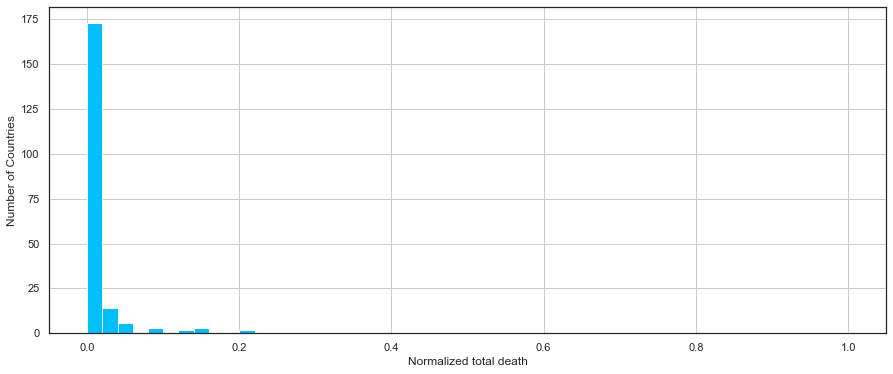

In [2472]:
# observe the histogram of normalized total death due to covid for all countries
plt.hist(norm_covid_df['norm_total_deaths'],bins=50,color='deepskyblue')
plt.xlabel('Normalized total death')
plt.ylabel('Number of Countries')
plt.grid(which='major', axis='both')
plt.show()


In [2473]:
norm_covid_2020['norm_total_deaths'].describe()

count    210.000000
mean       0.025463
std        0.093546
min        0.000000
25%        0.000125
50%        0.000969
75%        0.008371
max        1.000000
Name: norm_total_deaths, dtype: float64

,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million,norm_total_deaths
iso_code,,,,,,,,,,,,,,,,,,,,,
JOR,Asia,Jordan,2020-12-31,294494.0,7933.0,5678.714,3834.0,91.0,78.286,28677.901,...,NaN,NaN,1.40,74.53,0.729,4569.1,16.03,101.03,444.940132,0.010900
HRV,Europe,Croatia,2020-12-31,210837.0,4620.0,3647.571,3920.0,92.0,78.857,51654.757,...,39.9,NaN,5.54,78.49,0.851,4926.2,9.57,74.08,1206.911801,0.011144
PAN,North America,Panama,2020-12-31,246790.0,4574.0,3302.286,4022.0,52.0,44.429,56324.392,...,9.9,NaN,2.30,78.51,0.815,3015.6,14.46,51.17,688.244408,0.011434
BIH,Europe,Bosnia and Herzegovina,2020-12-31,110985.0,1953.0,1612.857,4050.0,86.0,59.000,34008.394,...,47.7,97.164,3.50,77.40,0.780,6595.8,18.22,94.24,2021.107052,0.011514
CHN,Asia,China,2020-12-31,87071.0,15133.0,4602.429,4634.0,1290.0,185.143,60.289,...,48.4,NaN,4.34,76.91,0.761,NaN,NaN,NaN,NaN,0.013174


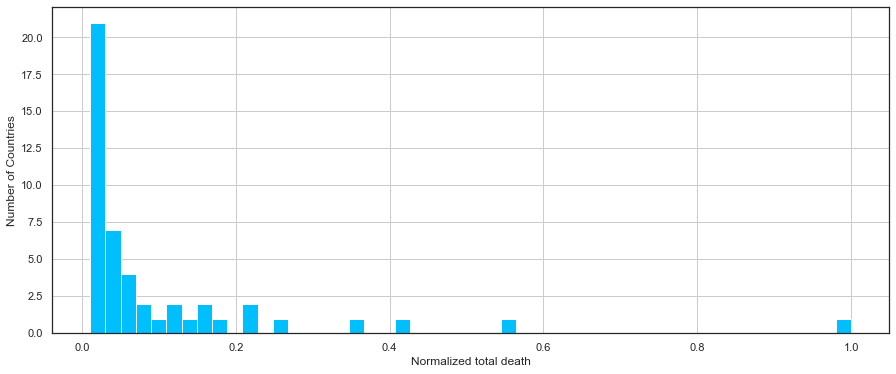

In [2474]:
# Let's observe the countries with over 75% percentail's covid death as serious countries
norm_covid_serious_df=norm_covid_df[norm_covid_df['norm_total_deaths']>=0.01] 
display(norm_covid_serious_df[:5])
plt.xlabel('Normalized total death')
plt.ylabel('Number of Countries')
plt.hist(norm_covid_serious_df['norm_total_deaths'],bins=50,color='deepskyblue')
plt.grid(which='major', axis='both')
plt.show()


### 2. Highest % of COVID deaths in the world<a class="anchor" id="highestdeath"></a>

We've tried to observe the countries, according to available data, that are suffering from the most COVID deaths since the beginning of the pandemic. The following analysis is to create a clean table with countries, associated deaths and number of deaths as a percentage of its population for better insight. 

In [43]:
covid = pd.read_csv("owid-covid-data.csv")[["location", "date", "new_deaths"]]

covid["date"] = pd.to_datetime(covid["date"]).dt.year

top_10_covid = covid.groupby(["location", "date"], as_index = False).sum()

display(top_10_covid[:3])

,location,date,new_deaths
0,Afghanistan,2020,2189.0
1,Afghanistan,2021,5167.0
2,Afghanistan,2022,0.0


In [44]:
worldpop = pd.read_csv("Worldpop.csv")

worldpop["PopTotal"] = worldpop["PopTotal"].astype(int)

display(worldpop[:3])

,Location,Time,PopTotal
0,Afghanistan,2020,38928
1,Afghanistan,2021,39943
2,Africa,2020,1340598


Join total population to covid deaths for comparison

In [45]:
top_10_covid = worldpop.merge(top_10_covid, left_on = ["Location", "Time"], right_on = ["location", "date"])

top_10_covid = top_10_covid.drop(columns = ["date", "location"])

In [46]:
display(top_10_covid[:3])

,Location,Time,PopTotal,new_deaths
0,Afghanistan,2020,38928,2189.0
1,Afghanistan,2021,39943,5167.0
2,Africa,2020,1340598,65468.0


Convert population to the accurate representation in 1000's 

In [47]:
# population total in 1000's 

top_10_covid["deaths percentage"] = (top_10_covid["new_deaths"]/(top_10_covid["PopTotal"]*1000))

top_10_covid = top_10_covid[top_10_covid["Location"] != "World"]

covid_countries = top_10_covid.sort_values(by = "deaths percentage", ascending = False)
covid_countries_df=covid_countries.copy() #save a copy

In [48]:
covid_countries = covid_countries[:10]

display(covid_countries[:3])

,Location,Time,PopTotal,new_deaths,deaths percentage
59,Bulgaria,2021,6892,23379.0,0.003392
282,Peru,2021,33283,109583.0,0.003292
164,Hungary,2021,9627,29649.0,0.003080


In [49]:
covid_trend = top_10_covid[top_10_covid["Location"].isin(covid_countries["Location"].unique())]

display(covid_trend[:3])

,Location,Time,PopTotal,new_deaths,deaths percentage
50,Bosnia and Herzegovina,2020,3280,4050.0,0.001235
51,Bosnia and Herzegovina,2021,3267,9392.0,0.002875
58,Bulgaria,2020,6948,7576.0,0.001090


Filter only for the top 10 Worst countries 

In [51]:
covid_trend = top_10_covid[top_10_covid["Location"].isin(covid_countries["Location"].unique())]
covid_trend = covid_trend.sort_values(by = ["deaths percentage", "Location"], ascending = False)

display(covid_trend[:3])

,Location,Time,PopTotal,new_deaths,deaths percentage
59,Bulgaria,2021,6892,23379.0,0.003392
282,Peru,2021,33283,109583.0,0.003292
164,Hungary,2021,9627,29649.0,0.003080


### 3. Barplot comparing 2020 and 2021<a class="anchor" id="covidbar"></a>

The analysis below visually displays the countries with the highest COVID death percentage. 

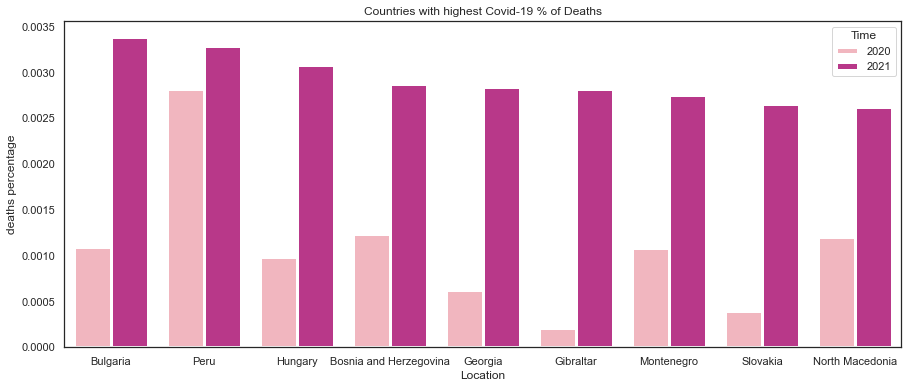

In [2483]:
sns.barplot(x="Location", y="deaths percentage",
             hue="Time",data=covid_trend, palette="RdPu", lw =3).set(title = "Countries with highest Covid-19 % of Deaths")

sns.set(rc={'figure.figsize':(15,6)})

sns.set_style("white")

The graph above shows the countries with the highest percentage of deaths compared to the population, either in 2021 or 2020. The data, showing both 2020 and 2021 values indicate the stark differences between certain countries. For example, while Peru observed a very high deaths percentage in 2020, the 2021 death percentage is not significantly higher. By contrast, Gibraltar observed a very small deaths percentage in 2020 but jumped significantly in 2021. Regardless of the year, these countries observed a high percentage of deaths. 

In [2484]:
# countries with most covid deaths 
continent = pd.read_csv("countryContinent.csv")

continent = continent[["country", "continent"]]

covid_deaths = covid_trend.merge(continent, left_on = "Location", right_on = "country")

covid_deaths = covid_deaths.drop(columns = ["country"])

display(covid_deaths["continent"].unique())

array(['Europe', 'Americas', 'Asia'], dtype=object)

This reveals that the countries suffering the most deaths during the pandemic are typically in Europe, the Americas or Asia.

### 4. Linear regression of malnutrition % and  COVID death %<a class="anchor" id="covidlinear"></a>

We want to use malnutrition data within the time frame that is more relatable to COVID, so we will take the mean of each percentages over 2015 and 2020.

In [2485]:
combined_covid=combined_df[(combined_df['Year']>=2015) & (combined_df['Year']<=2021)]
combined_covid=combined_covid.groupby(['Country Name'],as_index=False).mean()
del combined_covid['Year']
display(combined_covid[:3])

,Country Name,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean
0,Afghanistan,4.1,6.7,57.6,32.15
1,Albania,16.4,2.1,15.2,8.65
2,Algeria,12.8,4.0,13.2,8.60


Because we do not have 2021's malnutrition dataset, we want to take average of the country's COVID death percentage of 2020 and 2021 so we can see the generalized linear regression relationship between COVID death and malnutritions at country level.

In [2486]:
mean_covid_countries_df=covid_countries_df.groupby(['Location']).mean()
malnutrition_covid_df=mean_covid_countries_df.merge(combined_covid,left_on='Location',right_on='Country Name',how='inner')
display(malnutrition_covid_df[:5])

,Time,PopTotal,new_deaths,deaths percentage,Country Name,Overweight_percent,Waste_total_percent,Stunt_total_percent,Mean
0,2020.5,39435.5,3678.0,0.000093,Afghanistan,4.1,6.7,57.6,32.15
1,2020.5,2874.0,1608.5,0.000560,Albania,16.4,2.1,15.2,8.65
2,2020.5,44260.0,3138.0,0.000071,Algeria,12.8,4.0,13.2,8.60
3,2020.5,33412.5,885.0,0.000026,Angola,3.4,6.0,52.8,29.40
4,2020.5,2965.0,3986.0,0.001344,Armenia,13.7,6.1,13.2,9.65


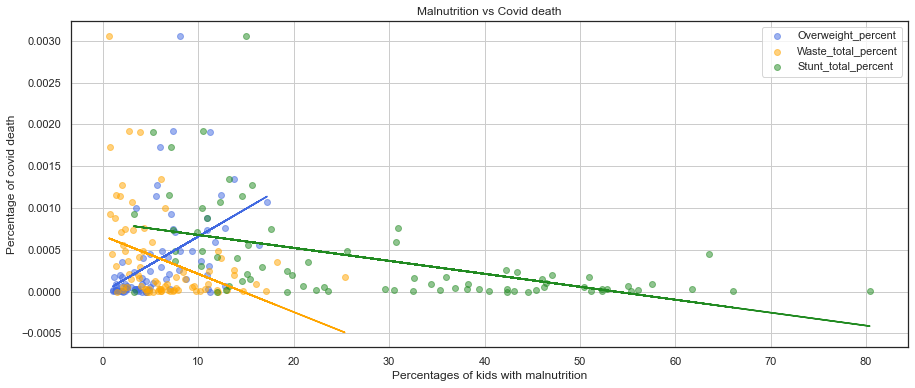

In [2487]:
x1=malnutrition_covid_df[mal_type[1]]
x2=malnutrition_covid_df[mal_type[2]]
x3=malnutrition_covid_df[mal_type[3]]
y=malnutrition_covid_df['deaths percentage']
#make scatter plot
plt.scatter(x1,y,color='royalblue',alpha=0.5)
plt.scatter(x2,y,color='orange',alpha=0.5)
plt.scatter(x3,y,color='forestgreen',alpha=0.5)

#linear fit : y = m*x1 + b
m1, b1 = np.polyfit(x1, y, 1)
plt.plot(x1, m1*x1 + b1, 'royalblue') # overweight
m2, b2 = np.polyfit(x2, y, 1)
plt.plot(x2, m2*x2 + b2, 'orange') # waste
m3, b3 =  np.polyfit(x3, y, 1)
plt.plot(x3, m3*x3 + b3, 'forestgreen') # stunt

#label graphs
plt.legend(mal_type[1:])
plt.xlabel('Percentages of kids with malnutrition')
plt.ylabel('Percentage of covid death')
plt.title('Malnutrition vs Covid death')
plt.grid(which='major', axis='both')
plt.show()

From linear regression, we see the overall trend is showing a higher percentage of overweight problem may corresponds to a higher percentages of COVID death, a higher percentages of waste and stunt may corresponds to a lower percentage of COVID death.\
\
However we do observe the lines are not fit very well, we could try fiting with higher degree or a log fit in the future.

### 5.  Creating a Scoring system for the countries<a class="anchor" id="covidscore"></a>

We created a scoring system for all countries to see if there is a possible corellation of malnutrition with COVID-19 survival rate.

The malnutrition score is the sum of all 3 types of malnutrition measurements for a final total 'score'.

The COVID-19 score is a function of total number of deaths divided by the length of time since the country first reported a death. Since the COVID-19 data covers a very short time span, countries can have vastly different total deaths depending on the length of time it has been present in each country. Since a glimpse at the data we retrieved seems to show daily reports, we have made an average daily deathrate by dividing the total deaths (as of 31 December 2020) by the number of days deaths have been in the reports by country.

In [105]:
# calculate a malnutrition score for each country
mal_score = combined_df.copy()
mal_score['mscore'] = mal_score['Overweight_percent']+mal_score['Waste_total_percent']+mal_score['Stunt_total_percent']
mal_score.drop(labels=['Overweight_percent', 'Waste_total_percent', 'Stunt_total_percent', 'Mean', 'Year'], axis=1, inplace=True)
mal_score = mal_score.groupby(by=['Country Name']).mean()
print('Malnutrition score range is from ', round(max(mal_score['mscore']),3), 'to', round(min(mal_score['mscore']),3))

Malnutrition score range is from  107.675 to 6.1


Since the malnutrition data is a percentage and the covid data is not a percentage, we need to normalize the data to the same scale as each other. We have chosen a scale of zero to ten because the graphs in this section respond best to this scale.

In [106]:
# normalize the score values
scaler = MinMaxScaler(feature_range=(0,10))
ms = scaler.fit_transform(mal_score)
scaled_mal_score = pd.DataFrame(ms, index=mal_score.index, columns=mal_score.columns)
print('Malnutrition score has been normalized to a range from ', round(max(scaled_mal_score['mscore']),3), 'to', round(min(scaled_mal_score['mscore']),3))
display(scaled_mal_score.head(2))

Malnutrition score has been normalized to a range from  10.0 to 0.0


,mscore
Country Name,
Afghanistan,7.793913
Albania,6.677332


In [107]:
# filter the covid dataframe to only have the columns necessary
covid_score = covid_data.copy()
covid_score = covid_score[['location', 'date', 'total_deaths']]

# count how many times the country name occurs so we know how many dates they have had COVID-19
counts = pd.DataFrame(covid_score['location'].value_counts(dropna=False))
counts.rename(columns={'location':'days_reported'}, inplace=True)
print('Count of the number of days each country has reported COVID-19 data.')
display(counts.head())

Count of the number of days each country has reported COVID-19 data.


,days_reported
Argentina,732
Peru,732
Mexico,732
Thailand,729
Taiwan,717


In [108]:
# find last known total number of deaths for each country
deaths = covid_score.groupby(by='location').max()
print('Total number of deaths by country')
display(deaths.head(2))

Total number of deaths by country


,date,total_deaths
location,,
Afghanistan,2022-01-01,7356.0
Africa,2022-01-01,228090.0


In [109]:
# calculate the covid score for each country
cscore =  deaths.merge(counts, left_on='location', right_index=True)
cscore['cscore'] = cscore['total_deaths'] / cscore['days_reported']
cscore.drop(labels=['date', 'total_deaths', 'days_reported'], axis=1, inplace=True)

# there were 7 countries with no covid score
cscore.fillna(0, inplace=True) 

# filter to only have countries (list from mapping section), not regions or 'World'
cscore = cscore[cscore.index.isin(countries)]
print('Covid score range is from ', round(max(cscore['cscore']),3), 'to', round(min(cscore['cscore']),3))
display(cscore.head(2))

Covid score range is from  1161.485 to 0.0


,cscore
location,
Afghanistan,10.849558
Albania,4.751846


In [110]:
# normalize the score values and use the same scaler as above
cs = scaler.fit_transform(cscore)
scaled_covid_score = pd.DataFrame(cs, index=cscore.index, columns=cscore.columns)
print('Covid score has been normalized to a range is from ', round(max(scaled_covid_score['cscore']),3), 'to', round(min(scaled_covid_score['cscore']),3))

Covid score has been normalized to a range is from  10.0 to 0.0


In [111]:
# join the scores for comparison
merged_scores = scaled_mal_score.merge(scaled_covid_score, left_index=True, right_index=True)
display(merged_scores.head(2))

,mscore,cscore
Afghanistan,7.793913,0.093411
Albania,6.677332,0.040912


#### Boxplot to view newly calculated scores distribution

Text(0.5, 1.0, 'COVID-19 score distribution')

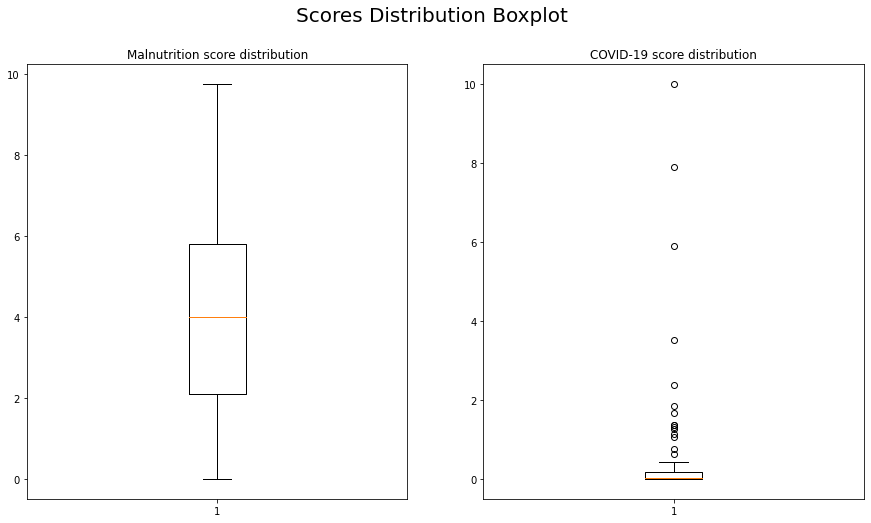

In [119]:
# now observe distribution
fig, axis2 = plt.subplots(1,2) 
fig.suptitle("Scores Distribution Boxplot", fontsize=20)

# Malnutrition score
axis2[0].boxplot(merged_scores['mscore'])
axis2[0].set_title("Malnutrition score distribution")

# COVID-19 score
axis2[1].boxplot(merged_scores['cscore'])
axis2[1].set_title("COVID-19 score distribution")

The distribution of the COVID-19 score is highly skewed to the right (large portion of the data is small with a long tail to the larger values) because this is still very new information with very little data and has not had time to normalize. We believe the data distribution will change over time.

#### Scatter plot

Viewing a scatter plor of the COVID-19 score versus the malnutrition score will give us a good idea of the correlation of the data. We can also visually see if there are any obvious outliers.

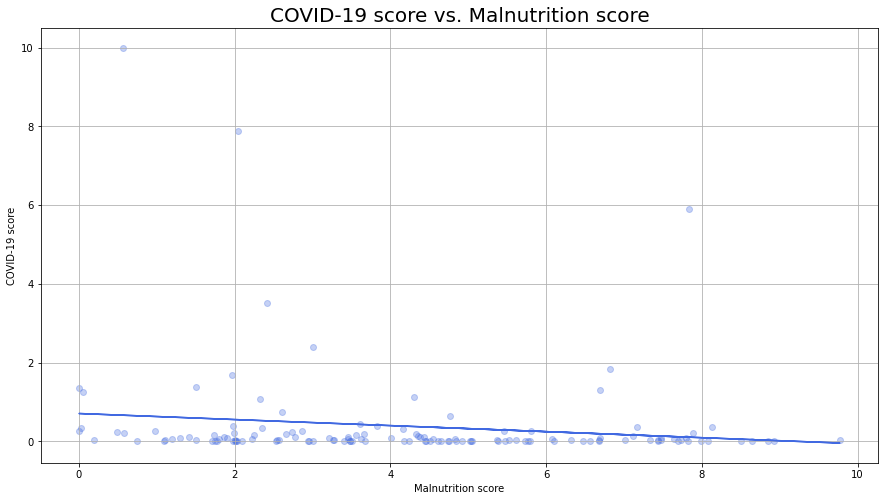

In [113]:
# scatterplot of scores to look for correlation
x1 = merged_scores['mscore']
y1 = merged_scores['cscore']

plt.figure(figsize=(15, 8))
plt.scatter(x1, y1, color='royalblue', alpha=0.3)
plt.title('COVID-19 score vs. Malnutrition score', fontsize=20)
plt.xlabel("Malnutrition score")
plt.ylabel("COVID-19 score")

m1, b1 = np.polyfit(x1, y1, 1)
plt.grid(which='major', axis='both')
plt.plot(x1, m1*x1 +b1, 'royalblue')



Upon initial inspection of the skatter plot, we see there is likely not much correlation between COVID-19 death and malnutrition based on the scoring system we created. Let's explore it a bit further though.

#### Interaction term

Creating an interaction term is a measurable way to see the effect of malnutrition on COVID-19 deathrate based on the scores we just created and assigned to each country. This interaction term is the malnutrition score times the COVID-19 score. By multiplying the two scores, we zero out countries for which we have '0' for either score data.

In [120]:
# now create an interaction term for easy comparison
merged_scores['interaction_term'] = merged_scores['mscore'] * merged_scores['cscore']
merged_scores = merged_scores.sort_values(by=['interaction_term'], ascending=False)
display('Top 10 countries where COVID-19 death rate has a large interaction rate with to malnutrition', merged_scores[:10])#, 'Bottom 5', merged_scores[-5:])

'Top 10 countries where COVID-19 death rate has a large interaction rate with to malnutrition'

,mscore,cscore,interaction_term
India,7.830011,5.900254,46.199055
Brazil,2.044466,7.888377,16.127522
Indonesia,6.814106,1.848910,12.598668
Ukraine,6.694561,1.314580,8.800538
Mexico,2.416230,3.521824,8.509537
Peru,3.006399,2.384007,7.167277
United States,0.570112,10.000000,5.701117
South Africa,4.297317,1.129762,4.854944
Colombia,1.967019,1.677865,3.300393
Philippines,4.761014,0.631273,3.005502


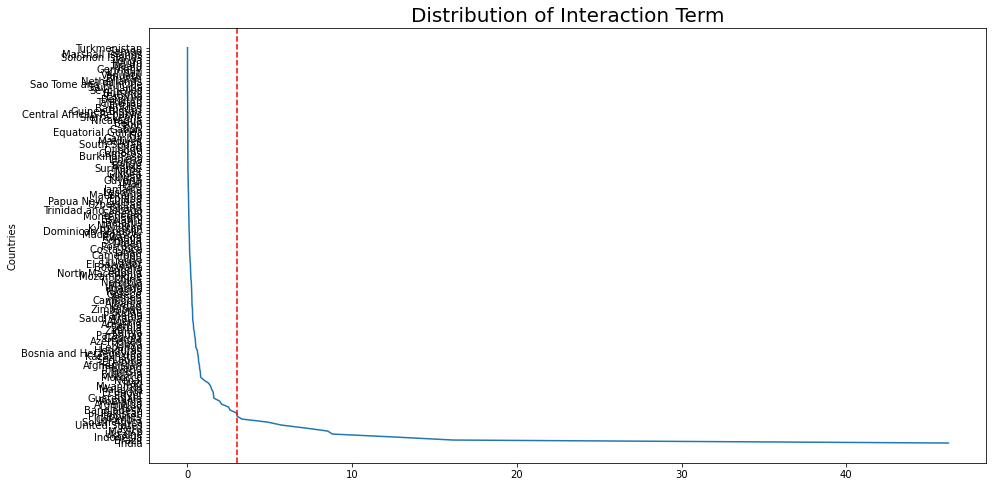

In [115]:
plt.figure(figsize=(15, 8))
plt.plot(merged_scores['interaction_term'],merged_scores.index)
plt.axvline(x=3, color='red', linestyle='--')
plt.title('Distribution of Interaction Term', fontsize=20)
plt.ylabel('Countries')
plt.show()

Now, let's isolate the outliers and look at those countries. Based on the distribution charted above, we'll call outliers any country with an interaction term of 3 or greater.

In [116]:
# isolate the outliers
outliers = merged_scores[merged_scores.interaction_term >= 3]
display(outliers)

,mscore,cscore,interaction_term
India,7.830011,5.900254,46.199055
Brazil,2.044466,7.888377,16.127522
Indonesia,6.814106,1.848910,12.598668
Ukraine,6.694561,1.314580,8.800538
Mexico,2.416230,3.521824,8.509537
Peru,3.006399,2.384007,7.167277
United States,0.570112,10.000000,5.701117
South Africa,4.297317,1.129762,4.854944
Colombia,1.967019,1.677865,3.300393
Philippines,4.761014,0.631273,3.005502


#### Bubble plot

This bubble plot shows countries who have a large interaction term calculated by multiplying the malnutrition scores and COVID-19 scores we created. The bubble size is representative of the value of the interaction term whereas the bubble placement shows which score has the most weight in the calculation.

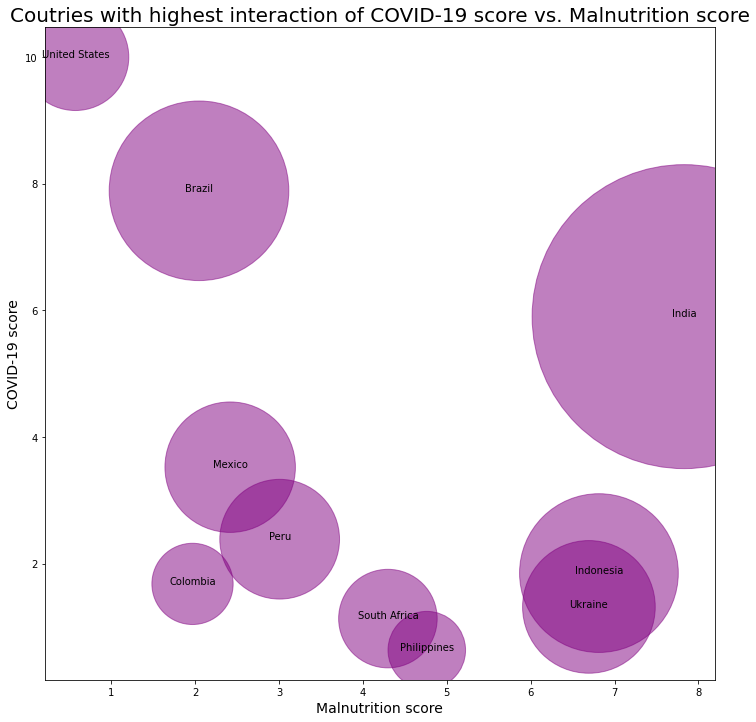

In [125]:
plt.figure(figsize=(12, 12))
plt.scatter(outliers['mscore'], outliers['cscore'],
            color = 'purple',  # can also be c=outliers['interaction_term']
            alpha=0.5,
            s = outliers['interaction_term'] * 2000)
plt.title('Coutries with highest interaction of COVID-19 score vs. Malnutrition score', fontsize=20)
plt.xlabel('Malnutrition score', size=14)
plt.ylabel('COVID-19 score', size=14)

for i, c in enumerate(list(outliers.index)):
    plt.annotate(c, (outliers['mscore'][i], outliers['cscore'][i]), ha='center')

## About the authors:

The authors met as students in Georgia Institue of Technology's Master of Science in Analytics program.  They were in a study group together for the Introduction for Computing for Data Analytics (CSE 6040) class in Fall 2021.

#### Yuxin Liu


https://www.linkedin.com/in/yuxin-liu-97108bb0/

#### Rutuja Patil

https://www.linkedin.com/in/rutuja-patil-b2804413b/

#### Kimberly Austin

https://www.linkedin.com/in/kimberly-austin-ga/

Modified: 08 Jan 2022